* [Datengrundlage]
    * [Daten einlesen](#einlesen)
    * [Datenmatrix erstellen](#matrix)
    * [Matrix überprüfen](#strukturtest)
* [Analyse]
    * [Clusteranzahl](#numcluster)
    * [Dimensionality Reduction](#dimred)
        * [PCA](#pca)
        * [t-SNE](#tsne)
        * [UMAP](#umap)
* [Clustering]
    * [Labor](#labor)
    * [Vital](#vital)

In [1]:
import pandas as pd
import datetime as dt
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy import stats
import plotly.express as px
import numpy as np
import operator
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import umap.umap_ as umap
import random
import itertools
import os 

In [20]:
image_path = './images_clustering/'
days_interval = 5

## Daten einlesen

In [2]:
df = pd.read_csv('./data/Daten_COPRA_all_subset_80.csv', error_bad_lines=False, warn_bad_lines=False, sep = ';', parse_dates=['Zeitstempel'])

In [8]:
list_patients = df.FallNr.unique()

#### Vitalwerte

In [4]:
filename = 'X_vital_all_294_35.txt'
X_vital_all = np.loadtxt(filename).reshape(int(filename.split('_')[-2]),int(filename.split('_')[-1].split('.')[0]))

In [5]:
filename = 'X_vital_all_hour_294_840.txt'
X_vital_all_hour = np.loadtxt(filename).reshape(int(filename.split('_')[-2]),int(filename.split('_')[-1].split('.')[0]))

#### Laborwerte

In [71]:
filename = 'X_labor_all_294_1850.txt'
X_labor_all = np.loadtxt(filename).reshape(int(filename.split('_')[-2]),int(filename.split('_')[-1].split('.')[0]))

<a class="anchor" id="numcluster"></a>

# Analysis

## How many clusters?

### Labor

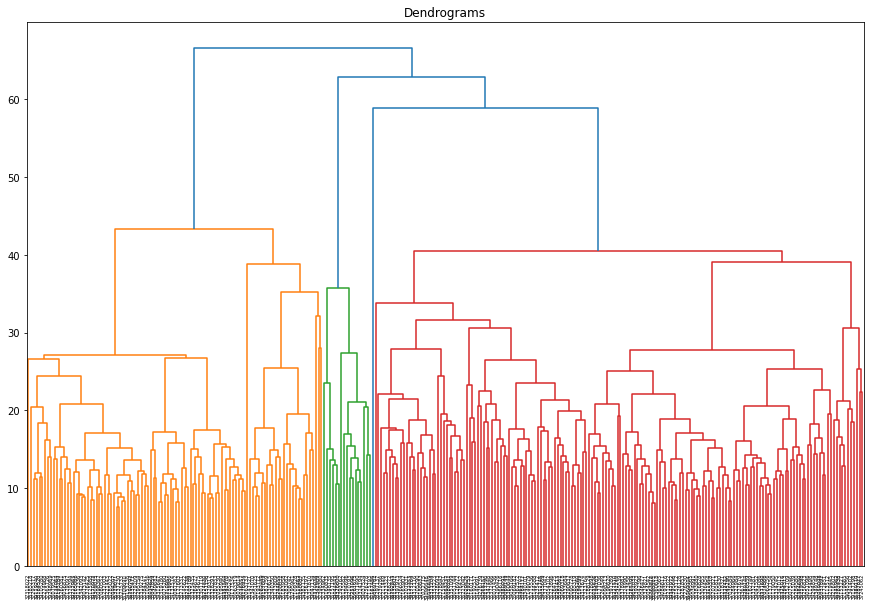

In [78]:
plt.figure(figsize=(15, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X_labor_all, method='ward'), labels=sorted(df.FallNr.unique()))
plt.savefig(image_path+'dendrogram_labor_all.png', dpi=400)

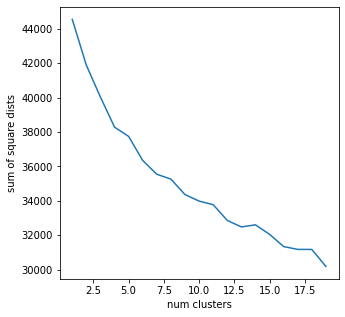

<Figure size 432x288 with 0 Axes>

In [85]:
sum_dist = []
for i in range(1,20):
    model = KMeans(n_clusters = i, init = "k-means++")
    model.fit(X_labor_all)
    sum_dist.append(model.inertia_)
plt.figure(figsize=(5,5))
plt.plot(range(1,20), sum_dist)
plt.xlabel('num clusters')
plt.ylabel('sum of square dists')
plt.show()
plt.savefig(image_path+'elbow_labor_all.png', dpi=400)

### Vital

X_vital_all

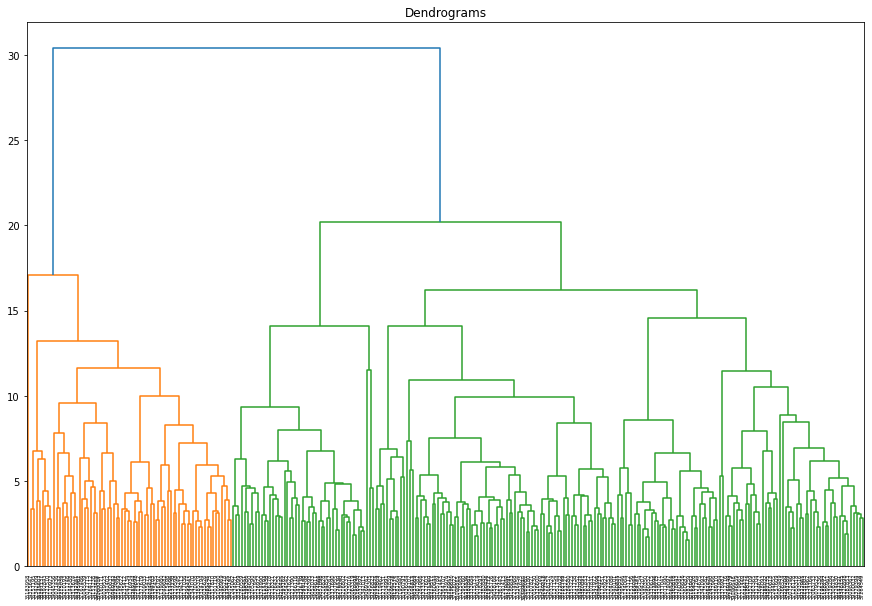

In [13]:
plt.figure(figsize=(15, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X_vital_all, method='ward'), labels=sorted(list_patients))
plt.savefig(image_path+'dendrogram_vital_all.png', dpi=400)

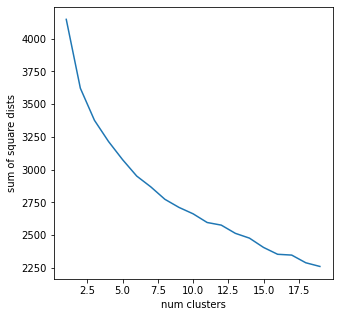

<Figure size 432x288 with 0 Axes>

In [14]:
sum_dist = []
for i in range(1,20):
    model = KMeans(n_clusters = i, init = "k-means++")
    model.fit(X_vital_all)
    sum_dist.append(model.inertia_)
plt.figure(figsize=(5,5))
plt.plot(range(1,20), sum_dist)
plt.xlabel('num clusters')
plt.ylabel('sum of square dists')
plt.show()
plt.savefig(image_path+'elbow_vital_' + '.png', dpi=400)

 X_vital_all_hour

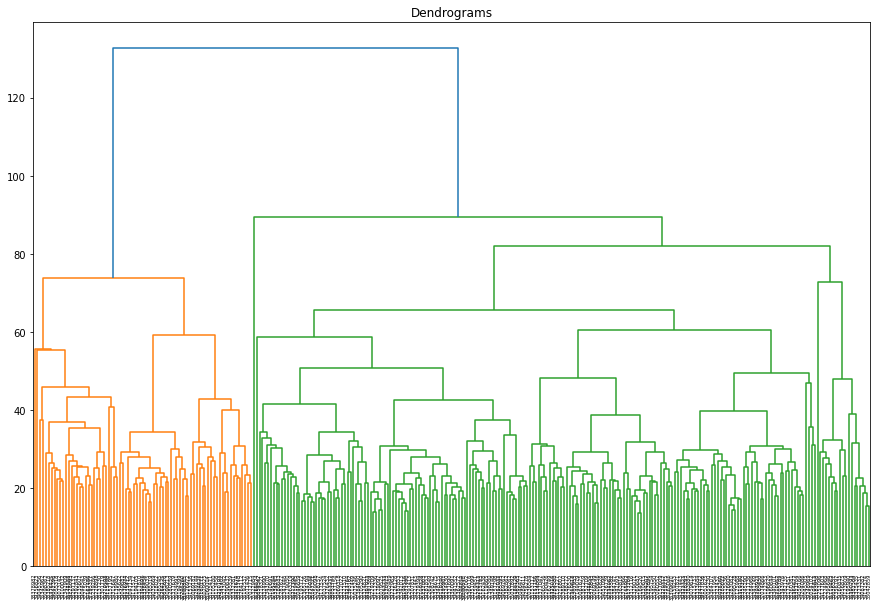

In [15]:
plt.figure(figsize=(15, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X_vital_all_hour, method='ward'), labels=sorted(list_patients))
plt.savefig(image_path+'dendrogram_vital_all.png', dpi=400)

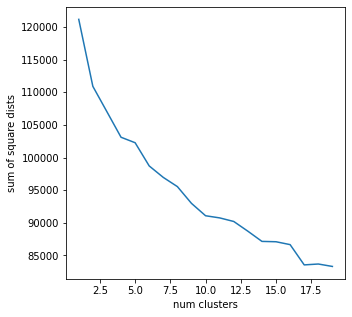

<Figure size 432x288 with 0 Axes>

In [16]:
sum_dist = []
for i in range(1,20):
    model = KMeans(n_clusters = i, init = "k-means++")
    model.fit(X_vital_all_hour)
    sum_dist.append(model.inertia_)
plt.figure(figsize=(5,5))
plt.plot(range(1,20), sum_dist)
plt.xlabel('num clusters')
plt.ylabel('sum of square dists')
plt.show()
plt.savefig(image_path+'elbow_vital_all_hour.png', dpi=400)

## Dimensionality Reduction

### PCA

In [17]:
def pca_components_names(pca_comp, ident_list, days_interval, hour=False):
    if hour == False:
        n_pcs = pca_comp.components_.shape[0]
        most_important = [np.abs(pca_comp.components_[i]).argmax() for i in range(n_pcs)]

        temp1 = list(itertools.chain.from_iterable(itertools.repeat(x, days_interval) for x in ident_list))
        temp2 = list(range(1,days_interval+1))*len(temp1)
        initial_feature_names = [m+'_'+str(n) for m,n in zip(temp1, temp2)]
        most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

        dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

        df_pca = pd.DataFrame(dic.items())
    else:
        n_pcs = pca_comp.components_.shape[0]
        most_important = [np.abs(pca_comp.components_[i]).argmax() for i in range(n_pcs)]

        temp1 = list(itertools.chain.from_iterable(itertools.repeat(x, days_interval*24) for x in ident_list))
        temp2 = list(range(1,days_interval+1))*len(ident_list)*24
        temp3 = list(range(0,24))*days_interval*len(ident_list)
        initial_feature_names = [m+'_day-'+str(n)+'_hour-'+str(o) for m,n,o in zip(temp1, temp2, temp3)]
        most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

        dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

        df_pca = pd.DataFrame(dic.items())
        
    return df_pca

In [90]:
pca_labor = PCA(n_components=2)
pca_data_labor = pca_labor.fit_transform(X_labor_all)

In [18]:
pca_vital = PCA(n_components=2).fit(X_vital_all)
pca_data_vital =  pca_vital.transform(X_vital_all)

pca_vital_hour = PCA(n_components=2).fit(X_vital_all_hour)
pca_data_vital_hour =  pca_vital_hour.transform(X_vital_all_hour)

In [101]:
cat = 'Labor'
ident_list = df[df.Kategorie==cat]['Wertbezeichner']
df_pca = pca_components_names(pca_labor, ident_list, days_interval, hour=False)
print(df_pca.values)
# wieviel erklären die achsen insgesamt an varianz 
print(np.array2string(pca_labor.explained_variance_))
print(np.array2string(pca_labor.explained_variance_ratio_))

[['PC0' 'K+_1']
 ['PC1' '-Thrombozyten_1']]
[13.59074738 12.03349994]
[0.08938003 0.07913873]


In [21]:
cat = 'Vitalwert'
ident_list = df[df.Kategorie==cat]['Wertbezeichner']
df_pca = pca_components_names(pca_vital, ident_list, days_interval, hour=False)
print(df_pca.values)
# wieviel erklären die achsen insgesamt an varianz 
print(np.array2string(pca_vital.explained_variance_))
print(np.array2string(pca_vital.explained_variance_ratio_))

[['PC0' 'HF_3']
 ['PC1' 'HF_1']]
[2.71078388 1.74039593]
[0.19150783 0.12295316]


In [22]:
cat = 'Vitalwert'
ident_list = df[df.Kategorie==cat]['Wertbezeichner']
df_pca = pca_components_names(pca_vital_hour, ident_list, days_interval, hour=False)
print(df_pca.values)
# wieviel erklären die achsen insgesamt an varianz 
print(np.array2string(pca_vital_hour.explained_variance_))
print(np.array2string(pca_vital_hour.explained_variance_ratio_))

[['PC0' 'HF_4']
 ['PC1' 'SPO2_5']]
[52.60220713 30.31789498]
[0.12721018 0.07331907]


In [137]:
#  welche features tragen zu den beiden achsen jeweils wie stark bei
(pca_vital.components_.T * np.sqrt(pca_vital.explained_variance_ratio_)).max()

0.1602675723648613

### UMAP

In [116]:
reducer = umap.UMAP()
umap_data_labor = reducer.fit_transform(X_labor_all)

In [23]:
reducer = umap.UMAP()
umap_data_vital = reducer.fit_transform(X_vital_all)

In [24]:
reducer = umap.UMAP()
umap_data_vital_hour = reducer.fit_transform(X_vital_all_hour)

# Clustering

## Labor
<a class="anchor" id="labor"></a>

In [107]:
cluster_pca_labor = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster_pca_labor.fit_predict(pca_data_labor)
fig = go.Figure([go.Scatter(x=pca_data_labor[:,0], 
                            y=pca_data_labor[:,1], 
                            marker={'color':cluster_pca_labor.labels_}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=px.colors.sequential.Rainbow)])

fig.show()
fig.write_html(image_path+'cluster_labor_all_pca.html')

In [119]:
cluster_umap_labor = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster_umap_labor.fit_predict(umap_data_labor)
fig = go.Figure([go.Scatter(x=umap_data_labor[:,0], 
                            y=umap_data_labor[:,1], 
                            marker={'color':cluster_umap_labor.labels_}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=px.colors.sequential.Rainbow)])

fig.show()
fig.write_html(image_path+'cluster_labor_all_umap.html')

In [129]:
kmeans_umap_labor = KMeans(n_clusters=4, random_state=0).fit(umap_data_labor)
fig = go.Figure([go.Scatter(x=umap_data_labor[:,0], 
                            y=umap_data_labor[:,1], 
                            marker={'color':kmeans_umap_labor.labels_}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=px.colors.sequential.Rainbow)])

fig.show()
fig.write_html(image_path+'kmeans_labor_all_umap_.html')

## Vital
<a class="anchor" id="vital"></a>

In [31]:
cluster_pca_vital = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster_pca_vital.fit_predict(pca_data_vital)
fig = go.Figure([go.Scatter(x=pca_data_vital[:,0], 
                            y=pca_data_vital[:,1], 
                            marker={'color':cluster_pca_vital.labels_}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=px.colors.sequential.Rainbow)])

fig.show()
fig.write_html(image_path+'cluster_vital_all_pca.html')

In [32]:
cluster_umap_vital = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster_umap_vital.fit_predict(umap_data_vital)
fig = go.Figure([go.Scatter(x=umap_data_vital[:,0], 
                            y=umap_data_vital[:,1], 
                            marker={'color':cluster_umap_vital.labels_}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=px.colors.sequential.Rainbow)])

fig.show()
fig.write_html(image_path+'cluster_vital_all_umap.html')

In [33]:
kmeans_umap_vital = KMeans(n_clusters=4, random_state=0).fit(umap_data_vital)
fig = go.Figure([go.Scatter(x=umap_data_vital[:,0], 
                            y=umap_data_vital[:,1], 
                            marker={'color':kmeans_umap_vital.labels_}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=px.colors.sequential.Rainbow)])

fig.show()
fig.write_html(image_path+'kmeans_vital_all_umap_.html')

In [34]:
cluster_pca_vital_hour = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster_pca_vital_hour.fit_predict(pca_data_vital_hour)
fig = go.Figure([go.Scatter(x=pca_data_vital_hour[:,0], 
                            y=pca_data_vital_hour[:,1], 
                            marker={'color':cluster_pca_vital_hour.labels_}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=px.colors.sequential.Rainbow)])

fig.show()
fig.write_html(image_path+'cluster_vital_all_hour_pca.html')

In [35]:
cluster_umap_vital_hour = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster_umap_vital_hour.fit_predict(umap_data_vital_hour)
fig = go.Figure([go.Scatter(x=umap_data_vital_hour[:,0], 
                            y=umap_data_vital_hour[:,1], 
                            marker={'color':cluster_umap_vital_hour.labels_}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=px.colors.sequential.Rainbow)])

fig.show()
fig.write_html(image_path+'cluster_vital_hour_all_umap.html')

In [36]:
kmeans_umap_vital_hour = KMeans(n_clusters=3, random_state=0).fit(umap_data_vital_hour)
fig = go.Figure([go.Scatter(x=umap_data_vital_hour[:,0], 
                            y=umap_data_vital_hour[:,1], 
                            marker={'color':kmeans_umap_vital_hour.labels_}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=px.colors.sequential.Rainbow)])

fig.show()
fig.write_html(image_path+'kmeans_vital_hour_all_umap_.html')

## Notizen

In [ ]:
def cluster_patients(list_patients, list_clusters):
    clusters = list(set(list_clusters))
    pat_dict = {i : [] for i in clusters}
    for p in range(len(list_patients)):
        current_cluster = list_clusters[p]
        current_patient = list_patients[p]
        pat_dict[current_cluster].append(current_patient)
    return pat_dict

In [ ]:
cluster_vital = cluster_patients(list(df.FallNr.unique()), list(cluster_umap_vital.fit_predict(umap_data_vital)))

In [ ]:
cluster_labor = cluster_patients(list(df.FallNr.unique()), list(cluster_umap_labor.fit_predict(umap_data_labor)))

- Beschreibung, Pro/Contra dimensionality reduction Verfahren
- PCA Auswertung Bedeutung für mich
- Cluster Analyse Bedeutung
- 20% der Daten weglassen
- PCA loadings mit Spalten des Dataframes zippen, für PC1: 0.5 * HF An Tag 3 + 0.2 * AF An Tag 5 etc.
- wie viele Cluster?
- Daten für RR 
- Dendrogram

In [ ]:
def column(matrix, i):
    return [row[i] for row in matrix]

In [ ]:
X_temp = pd.DataFrame(X_vital)
X_temp['43'] = column(pca_data_vital, 0)
X_temp['44'] = column(pca_data_vital, 1)
X_temp